In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
txt =  'theta_{}x theta_{}y theta_{}z'
fulltxt = ''
for i in range(4):
    fulltxt += txt.format(i, i, i) + ' '
control_params = list(sympy.symbols(fulltxt))

In [3]:
qubit = cirq.GridQubit.rect(1, 4)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit[0]),
    cirq.ry(control_params[1])(qubit[0]),
    cirq.rx(control_params[2])(qubit[0]),
    cirq.rz(control_params[3])(qubit[1]),
    cirq.ry(control_params[4])(qubit[1]),
    cirq.rx(control_params[5])(qubit[1]),
    cirq.rz(control_params[6])(qubit[2]),
    cirq.ry(control_params[7])(qubit[2]),
    cirq.rx(control_params[8])(qubit[2]),
    cirq.rz(control_params[9])(qubit[3]),
    cirq.ry(control_params[10])(qubit[3]),
    cirq.rx(control_params[11])(qubit[3]),
    cirq.CX(qubit[0], qubit[1]),
    cirq.CX(qubit[2], qubit[3]),
    cirq.CX(qubit[1], qubit[2])
    )

In [51]:
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(36, activation='elu'),
    tf.keras.layers.Dense(12)
])

preparation = cirq.Circuit(
    cirq.Z(qubit[0]),
    cirq.Z(qubit[1]),
    cirq.Z(qubit[2]),
    cirq.Z(qubit[3])
    )
datapoint_circuits = tfq.convert_to_tensor([preparation] * 1)

In [52]:
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.dtypes.string,
                                name='circuits_input')

commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

dense_2 = controller(commands_input)
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
full_circuit

<tf.Tensor 'add_circuit_2/Identity:0' shape=(None,) dtype=string>

In [53]:
dense_2

<tf.Tensor 'sequential_1_1/Identity:0' shape=(None, 12) dtype=float32>

In [171]:
state_layer = tfq.layers.State()
state = state_layer(full_circuit,
                    symbol_names=list(control_params),
                    symbol_values=dense_2)
state

tf.RaggedTensor(values=Tensor("state_9/PartitionedCall:0", shape=(None,), dtype=complex64), row_splits=Tensor("state_9/PartitionedCall:1", shape=(None,), dtype=int64))

In [55]:
# alphas = tf.constant(np.random.rand(12))
# state = state_layer(model_circuit,
#                     symbol_names=control_params,
#                     symbol_values=[alphas])
# state[0]

In [96]:
model = tf.keras.Model(
    inputs=[circuits_input, commands_input],
    outputs=state)

In [166]:
commands = tf.constant(np.array([0], dtype=np.float32))
expected_state = np.zeros((1, 16), dtype=np.complex64)
expected_state[0] = 1.
expected_outputs = tf.ragged.constant(expected_state, dtype=tf.complex64)

In [167]:
model([circuits_input, commands_input])

tf.RaggedTensor(values=Tensor("model_10_7/state_8/PartitionedCall:0", shape=(None,), dtype=complex64), row_splits=Tensor("model_10_7/state_8/PartitionedCall:1", shape=(None,), dtype=int64))

In [168]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
#loss = tf.keras.losses.MeanSquaredError()
def loss(predicted_y, target_y):
    print("predict: ", predicted_y)
    print("target: ", target_y)
    res = tf.math.reduce_sum(tf.math.abs(predicted_y - target_y))
    print("LOSS", res)
    return res

predict:  Tensor("state_8_target_11:0", shape=(None, None), dtype=complex64)
target:  tf.RaggedTensor(values=Tensor("state_8/PartitionedCall:0", shape=(None,), dtype=complex64), row_splits=Tensor("state_8/PartitionedCall:1", shape=(None,), dtype=int64))
LOSS Tensor("loss_26/state_8_loss/RaggedReduceSum:0", shape=(), dtype=float32)


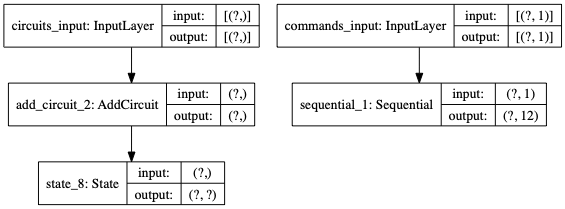

In [169]:
model.compile(optimizer=optimizer, loss=loss)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [170]:
history = model.fit(x=[datapoint_circuits, commands],
                    y=[expected_outputs],
                    epochs=30,
                    verbose=1)

Train on 1 samples
Epoch 1/30
predict:  tf.RaggedTensor(values=Tensor("RaggedFromVariant/RaggedTensorFromVariant:1", shape=(None,), dtype=complex64), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))
target:  tf.RaggedTensor(values=Tensor("model_10/state_8/PartitionedCall:0", shape=(None,), dtype=complex64), row_splits=Tensor("model_10/state_8/PartitionedCall:1", shape=(None,), dtype=int64))
LOSS Tensor("loss/state_8_loss/RaggedReduceSum:0", shape=(), dtype=float32)
1/1 [==============================] - 0s 283ms/sample


ValueError: All inputs to `ConcreteFunction`s must be Tensors; on invocation of __backward_padded_to_ragged_1909, the 0-th input (IndexedSlices(indices=Tensor("Reshape_9:0", shape=(None,), dtype=int64), values=Tensor("Reshape_8:0", shape=(None,), dtype=complex64), dense_shape=Tensor("Cast:0", shape=(1,), dtype=int32))) was not a Tensor.

In [154]:
A = tf.constant([1, 1], dtype = tf.complex64)
B = tf.ragged.constant([[1, 1]], dtype = tf.complex64)
C = tf.ragged.constant([[1, 0]], dtype = tf.complex64)
tf.math.reduce_sum(tf.math.abs(B - C))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

<tf.Tensor: shape=(2,), dtype=complex64, numpy=array([0.+0.j, 0.+0.j], dtype=complex64)>